# Section examples

The `xarray.interp` method makes it easy to extract a ROMS Dataset along a verical section.
The functionality is implemented in the function `section` in the `xroms` package.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cmo
import xroms
#%matplotlib notebook
%matplotlib inline

In [2]:
# Initiate the Dataset
A = xroms.roms_dataset("ocean_avg_0014.nc")

Define a linear section by the grid coordinates of the two end points.
For a quick check, draw it in a map

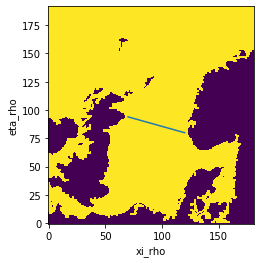

In [3]:
# Define a linear section, draw in map for quick control

# First and last end point
x0, y0 = 70,  94
x1, y1 = 120, 80
Npoints = 50
X = np.linspace(x0, x1, Npoints)
Y = np.linspace(y0, y1, Npoints)

# Plot
A.mask_rho.plot(add_colorbar=False)
plt.plot(X, Y)
plt.axis('image');

Make a section Dataset

In [4]:
B = xroms.section(A, X, Y)

Plot the vertical profile

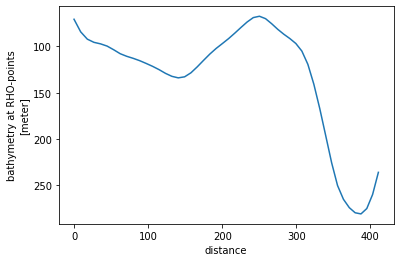

In [5]:
# Plot depth along section
B.h.plot(yincrease=False);

It is easy to plot a 3D field along the section in s-coordinates

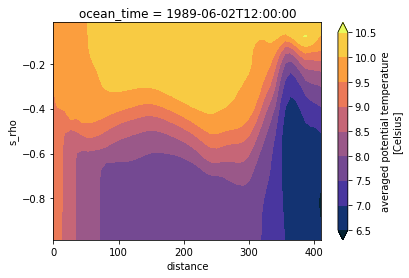

In [6]:
# Plot temperature in s-coordinates
T = B.temp.isel(ocean_time=3)
levels = np.arange(6.5, 11, 0.5)
T.plot.contourf(levels=levels, cmap=cmo.thermal);

Using the `z_rho` coordinate, the section can be plotted in z-coordinates.
This does not work with the `plot` method, but works nicely if `contourf` or
`pcolormesh` is indicated directly.

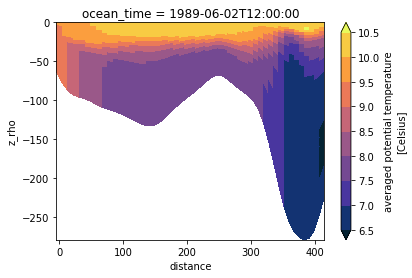

In [7]:
# T.plot.contourf('distance', 'z_rho', levels=levels, cmap=cmo.thermal)
T.plot.pcolormesh('distance', 'z_rho', levels=levels, cmap=cmo.thermal)

Make a similar plot of salinity. I prefer to reverse the `haline` colour map,
to have the darker colours at high salinity.

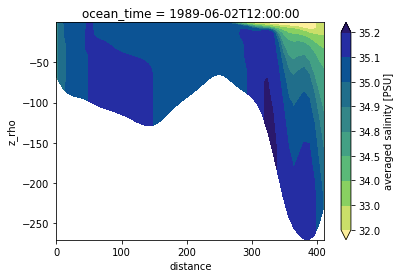

In [8]:
S = B.salt.isel(ocean_time=3)
levels = [32, 33, 34, 34.5, 34.8, 34.9, 35.0, 35.1, 35.2]
S.plot.contourf('distance', 'z_rho', levels=levels, cmap=cmo.haline_r)

The section Dataset has a DataArray with the normal velocity. A diverging colour map is used. 

The conventions are that the section is plotted from left to right and a positive velocity points into the screen.

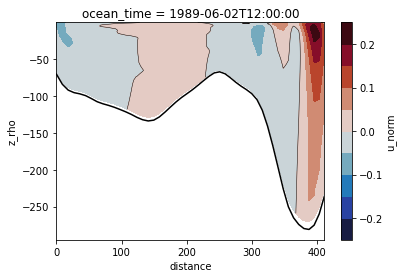

In [9]:
U = B.isel(ocean_time=3).u_norm
levels=np.arange(-0.25, 0.3, 0.05)
U.plot.contourf('distance', 'z_rho', levels=levels, cmap=cmo.balance)
# Add the zero velocity contour
U.plot.contour('distance', 'z_rho', levels=[0], colors='black', linewidths=0.5)
# Add the bottom profile
plt.plot(B.distance, -B.h, color='black');

The Fedje–Shetland section goes approximately from 1°W to 4°57'E along the parallel 60°N.

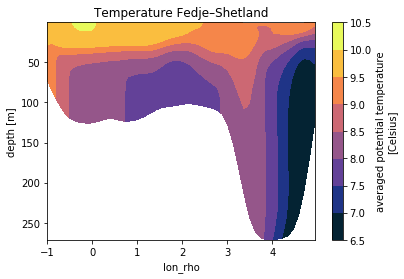

In [10]:
lon0, lat0 = -1, 60
lon1, lat1 = 4 + 57/60, 60
# Take 50 equidistant points along the section
lon = np.linspace(lon0, lon1, 50)
lat = np.linspace(lat0, lat1, 50)
# Transform to grid coordinates
X, Y = xroms.ll2xy(A, lon, lat)
# Take the section Dataset
S = xroms.section(A, X, Y)
# Add a depth coordinate
S['depth'] = -S.z_rho
S['depth'].attrs = {'units': 'm'}

# Plot temperature, using longitude as horizontal coordinate
temp = S.isel(ocean_time=3).temp
levels = np.arange(6.5, 11, 0.5)
temp.plot.contourf('lon_rho', 'depth', levels=levels,
                   cmap=cmo.thermal, yincrease=False)
plt.title("Temperature Fedje–Shetland");

### Quantitative information

Sections are great for vizualization, but they are also useful
for providing quantitative information. 
For this purpose, the `xroms` package provides DataArrays of
horizontal spacing `dS`, vertical spacing `dZ` and their product `area`.

For more precise flux calculations, an alternative approach following the
ROMS grid cell boundaries will be adapted to `xroms`.

Some example properties of the Fedje–Shetland section are computed below.

In [11]:
S3 = S.isel(ocean_time=3)     # Fix the time step

# Geometry
length = S3.dS.sum()
print(f"Total length of section    = {float(length)*1e-3:6.2f} km") 
depthmean = (S3.h * S3.dS).sum() / length
print(f"Mean depth                 = {float(depthmean):6.2f} m") 
TotArea = S3.area.sum()
print(f"Total area of section      = {float(TotArea)*1e-6:6.2f} km²") 

# Hydrography
print()
tempmean = (S3.area * S3.temp).sum() / TotArea
print(f"Mean temperature           = {float(tempmean):6.2f} °C")
temp8p = S3.area.where(S3.temp > 8).sum()
print(f"Area with temperature > 8  = {float(temp8p*1e-6):6.2f} km²")

# Flux
print()
flux = (S3.area * S3.u_norm)
netflux = flux.sum()
print(f"Total volume flux          = {float(netflux*1e-6):6.2f} Sv")
outflux = flux.where(S3.u_norm > 0).sum()
print(f"Northwards volume flux     = {float(outflux*1e-6):6.2f} Sv")
influx = flux.where(S3.u_norm < 0).sum()
print(f"Southwards volume flux     = {float(influx*1e-6):6.2f} Sv")
freshflux = flux.where(S3.salt < 34.9).sum()
print(f"Volume flux with S < 34.9  = {float(freshflux*1e-6):6.2f} Sv")
# Define Atlantic Water by S > 35.1
saltflux = flux.where(S3.salt > 35.1).sum()
print(f"Atlantic net volume flux   = {float(saltflux*1e-6):6.2f} Sv")
# Atlantic inflow
atl_flux = flux.where((S3.salt > 35.1) & (S3.u_norm < 0 )).sum()
print(f"Atlantic inflow            = {float(atl_flux*1e-6):6.2f} Sv")

# Add heat flux, salt flux
rho = 1025        # Sea water density, kg/m³
heat_cap = 4000.0 # Heat capacity, J/(kg K)
Tref = 0.0        # Reference temperature, °C

Tflux = rho * heat_cap * (flux * S3.temp).sum()
Sflux = rho * (flux * S3.salt).sum()
print()
print(f"Heat flux                  = {float(Tflux)*1e-12:6.2f} TW")
print(f"Salt flux                  = {float(Sflux)*1e-9:6.2f} Gg/s")

Total length of section    = 331.17 km
Mean depth                 = 156.51 m
Total area of section      =  51.83 km²

Mean temperature           =   8.23 °C
Area with temperature > 8  =  32.34 km²

Total volume flux          =   0.31 Sv
Northwards volume flux     =   0.85 Sv
Southwards volume flux     =  -0.54 Sv
Volume flux with S < 34.9  =   0.44 Sv
Atlantic net volume flux   =  -0.29 Sv
Atlantic inflow            =  -0.53 Sv

Heat flux                  =   7.43 TW
Salt flux                  =  10.85 Gg/s
